In [1]:
# Importing libraries and modules
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("MonodSDEsim.jl")
using .MonodSDEsim, Plots

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Biochemical Reaction Kinetics

Consider the following biochemical reactions

$$ 
\begin{align}
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{more Biomass X}, \\
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{Product Y}, \\
    \text{Product Y} &\xrightarrow{\text{Biomass X}} \text{Byproduct Z}.
\end{align}
$$

The biomass growth rate can be described using Monod model

$$
\mu(S) = \mu_{max}\frac{S}{K_S+S}
$$

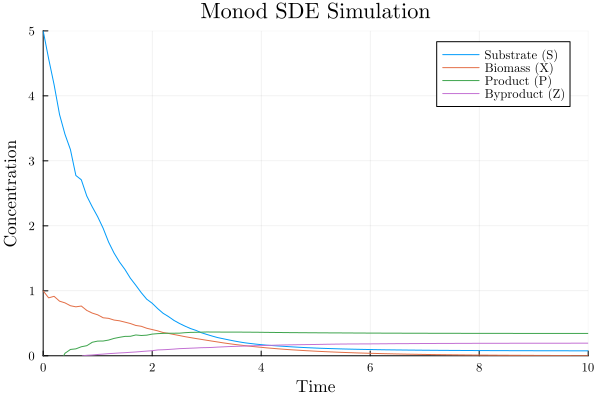

In [2]:
# Setting up the model parameters
# The parameters are defined in a dictionary for easy access and modification
params  = Dict(
    "μ_max" => 0.33, 
    "K_s" => 1.7, 
    "Y_sx" => 0.08, 
    "q_max" => 0.5, 
    "K_sp" => 0.5, 
    "Y_sp" => 0.5,
    "k_d" => 0.45, 
    "k_z" => 0.5, 
    "σ1" => 0.05, 
    "σ2" => 0.05, 
    "σ3" => 0.05
)

# Initial conditions for the state variables
# The initial conditions are defined in a dictionary for easy access and modification
init = Dict(
    "S0" => 5.0, 
    "X0" => 1.0, 
    "P0" => 0, 
    "Z0" => 0
)

# Time parameters
tspan = (0.0, 10.0)  # Time span for the simulation

sol = simulate(params, tspan, init)

# Plotting the results
plot(sol, title="Monod SDE Simulation", label=["Substrate (S)" "Biomass (X)" "Product (P)" "Byproduct (Z)"], xlabel="Time", ylabel="Concentration")
plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["S0"]), xlims=(0, 10),)